<img src='../OUTILS/bandeau_MF.png' align='right' width='100%'/>

<div class="alert alert-info alert-success">
<h3>Elaboration d'image composite avec SATPY- FCI /MTG </h3></div>

## <a id='TOC-TOP'></a>Contenus

<div class="alert alert-block alert-warning">
    
<b>PREREQUIS </b>
    
Ce Notebook ne nécessite pas de prérequis. 
Le kernel "env_MF_stage" doit être utilisé

</div>
<hr>

SatPy

Il s'agit d'une bibliothèque Python pour le traitement des données des satellites météorologiques

Satpy permet de lire, manipuler et écrire des données issues d'instruments satellites météorologiques d'observation de la Terre.

Satpy fournit la possibilité de lire les données de différents formats (readers) et de manipuler les paramètres géophysiques de ces différents formats de fichiers.

Satpy fournit également des interfaces pour créer des images RVB (rouge/vert/bleu) qui combinent les données de plusieurs bandes d'instruments ou produits.

Diverses corrections atmosphériques et améliorations visuelles sont fournies pour améliorer le rendu et la qualité des images de sortie. Les données de sortie peuvent être écrites dans plusieurs formats de fichiers tels que les fichiers NetCDF, PNG et GeoTIFF.

Satpy permet également aux utilisateurs de rééchantillonner les données sur des grilles géographiques projetées (zones).

Pour obtenir de la documentation sur Satpy, quelques exemples, et un tutoriel de démarrage rapide : https://satpy.readthedocs.io/en/latest/index.html

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1.Tout d'abord, il faut procéder à l'importation des librairies nécessaires.

</div>

In [1]:
from satpy.scene import Scene
from satpy import find_files_and_readers
from datetime import datetime
import sys
from pyresample.geometry import AreaDefinition
import numpy as np
import os
from osgeo import gdal
from PIL import Image
import subprocess
os.environ['PATH'] = f"~/.conda/envs/env_MF_stage/bin:{os.environ['PATH']}" 
os.environ['GDAL_DATA'] = '/home/coster/.conda/envs/env_MF_stage/share/gdal'
os.environ['PROJ_LIB'] = '/home/coster/.conda/envs/env_MF_stage/share/proj'

In [2]:
!gdalinfo

Usage: gdalinfo [--help-general] [-json] [-mm] [-stats | -approx_stats] [-hist] [-nogcp] [-nomd]
                [-norat] [-noct] [-nofl] [-checksum] [-proj4]
                [-listmdd] [-mdd domain|`all`] [-wkt_format WKT1|WKT2|...]*
                [-sd subdataset] [-oo NAME=VALUE]* [-if format]* datasetname

FAILURE: No datasource specified.


In [3]:
os.system("echo $PATH")

~/.conda/envs/env_MF_stage/bin:/opt/conda/jupyterhub/bin:/root/anaconda3/condabin:/root/.local/bin:/root/bin:/sbin:/bin:/usr/sbin:/usr/bin:/usr/local/bin


0

### Données d'entrée : fichiers chunk mtg (40)

In [4]:
input = '../../MF_DATA/chunk_decomp/'

In [5]:
download_dir = os.path.join(os.getcwd(), "../RESULTATS")
os.makedirs(download_dir, exist_ok=True)

In [6]:
output = '../RESULTATS'

### Choix de la RGB à produire, parmi notamment:
airmass ash cimss_cloud_type cloud_phase cloud_phase_distinction cloud_phase_distinction_raw cloud_phase_raw cloudtop convection day_microphysics dust fog geo_color green_snow ir108_3d ir_cloud_day natural_color ndvi_hybrid_green night_fog night_microphysics rocket_plume_day rocket_plume_night true_color true_color_reproduction 

In [7]:
composite_name = "dust"

### Définition de la date et heure de la composite à créer
(202401091200 disponible par défaut)

In [8]:
yyyy=int('2024')
mm=int('01')
dd=int('09')
hh_debut=int('12')
min_debut=int('00')
hh_fin=int('12')
min_fin=int('10')

In [9]:
### Définition du reader

In [10]:
reader_to_use = "fci_l1c_nc"

In [11]:
filename = (output + '/RGB_' + composite_name )

In [12]:
myfiles = find_files_and_readers(base_dir=input,
                                 start_time=datetime(yyyy,mm,dd,hh_debut,min_debut),
                                 end_time=datetime(yyyy,mm,dd,hh_fin,min_fin),
                                 reader=reader_to_use)

In [13]:
#!gdalinfo ../../MF_DATA/chunk_decomp/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY--DIS-NC4E_C_EUMT_20240109121040_IDPFI_OPE_20240109120908_20240109120924_N_JLS_C_0073_0040.nc

In [14]:
#!gdalinfo NETCDF:"../../MF_DATA/chunk_decomp/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY--DIS-NC4E_C_EUMT_20240109121040_IDPFI_OPE_20240109120908_20240109120924_N_JLS_C_0073_0040.nc":/data/vis_04/measured/pixel_quality

In [15]:
scn = Scene(filenames=myfiles)

### Liste de toutes les composites disponibles

In [16]:
#print(scn.available_composite_names())

### Liste de tous les dataset disponibles

In [17]:
#print(scn.available_dataset_names())

### Creation du produit

In [18]:
scn.load([composite_name], upper_right_corner='NE')

In [19]:
natscn = scn.resample(scn.coarsest_area(), resampler='nearest')

In [20]:
natscn.save_dataset(composite_name, filename=filename + '.tif')

### Défnition de la taille de l'image globe (pixels)

In [21]:
taille_redim = 800  # 5568x5568 par défaut

In [22]:
!gdalwarp -overwrite -ts ${taille_redim} ${taille_redim} {filename}.tif {filename}_redim.tif

Using band 4 of source image as alpha.
Creating output file that is 5568P x 5568L.
Processing ../RESULTATS/RGB_dust.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### Rappel : nom du fichier de sortie

In [23]:
!echo {filename}.tif

../RESULTATS/RGB_dust.tif


In [24]:
# Chemins vers les fichiers shapefile contenant les frontieres des pays
input_shapefile = '../OUTILS/boundary/world-administrative-boundaries.shp'  # Chemin vers le shapefile

### Ajout des frontières

In [42]:
!gdal_rasterize -q -b 1 -burn 255 -b 2 -burn 255 -b 3 -burn 255 -l world-administrative-boundaries ../OUTILS/boundary/world-administrative-boundaries.shp {filename}.tif >/dev/null 2>&1

### Affichage de l'image globe dans le jupyter notebook

Redimmensionnement de l'image pour un affichage plus facile

In [26]:
!convert -resize 500x500 {filename}.tif {filename}_min.jpg

convert: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/958.
convert: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/958.
convert: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/958.
convert: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/958.
convert: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/958.


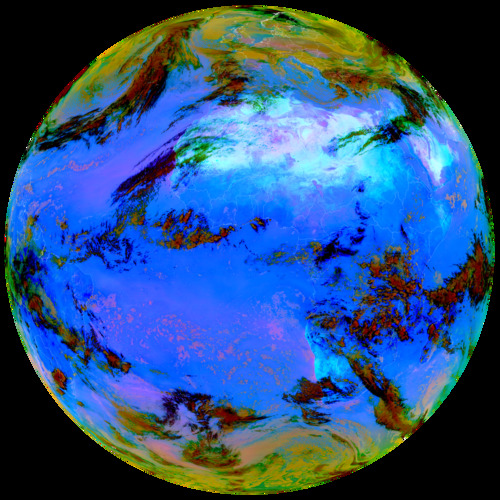

In [27]:
im = Image.open(filename + '_min.jpg')
display(im)

### Création d'une image à partir d'une zone de découpe 

In [28]:
### Définition de la zone, et redimmensionnement de l'image 

In [29]:
#exemple nord-ouest Afrique = 40,8,-23,15
coord_nord = 40
coord_sud = 8
coord_ouest = -23
coord_est = 15


In [30]:
# Facteur de mise à l'échelle
scale_factor = 0.04  # 0.04 par défaut

In [31]:
!gdalwarp -overwrite -t_srs "EPSG:4326" -te -23 8 15 40  {filename}.tif {filename}_decoupe_HD.tif
!gdalwarp -overwrite -t_srs "EPSG:4326" -te -23 8 15 40  {filename}.tif {filename}_decoupe_HD.jpg

Using band 4 of source image as alpha.
Creating output file that is 2079P x 1751L.
Processing ../RESULTATS/RGB_dust.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Using band 4 of source image as alpha.
Creating output file that is 2079P x 1751L.
0Warning 1: 4-band JPEGs will be interpreted on reading as in CMYK colorspace
...10...20...30...40...50...60...70...80...90...100 - done.


In [32]:
!ls -ltr {filename}_decoupe_HD.tif {filename}_decoupe_HD.jpg

-rw-r--r--. 1 coster coster 14572248 Oct  4 13:17 ../RESULTATS/RGB_dust_decoupe_HD.tif
-rw-r--r--. 1 coster coster  1550830 Oct  4 13:17 ../RESULTATS/RGB_dust_decoupe_HD.jpg


In [33]:
!ls ../RESULTATS/RGB_dust_decoupe_HD.jpg

../RESULTATS/RGB_dust_decoupe_HD.jpg


In [34]:
!echo {filename}_decoupe_HD.jpg

../RESULTATS/RGB_dust_decoupe_HD.jpg


In [35]:
!convert -resize 500 {filename}_decoupe_HD.jpg {filename}_decoupe_min.png

ValueError: Could not save to PNG for display

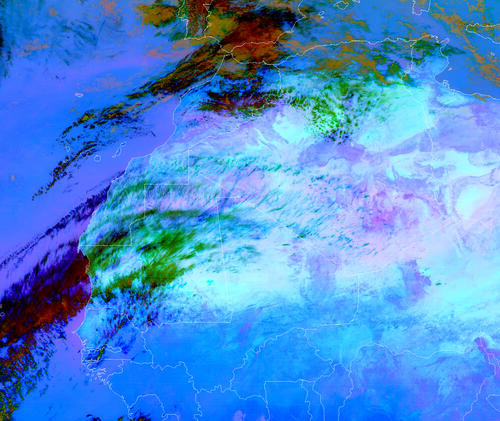

In [36]:
im2 = Image.open(filename + '_decoupe_min.jpg')
display(im2)

In [37]:
#sauvegarde du tif d'origine (gdal_rasterize écrase)
!cp {filename_image_zoom_out + ".tif"} {filename_image_zoom_out + "_contour.tif"}

cp: target '_contour.tif}' is not a directory


#### Ajout des frontières

In [38]:
# Définir la commande gdal_rasterize
cmd4 = [
    'gdal_rasterize',
    '-b', '1' ,
    '-burn', '255',  # Valeur de brûlure
    '-b', '2' ,
    '-burn', '255',  # Valeur de brûlure
    '-b', '3' ,
    '-burn', '255',  # Valeur de brûlure
    '-l', 'world-administrative-boundaries',  # Nom de la couche
    input_shapefile,  # Chemin vers le shapefile
    filename_image_zoom_out + "_contour.tif"  # Chemin vers l'image raster de sortie
]

NameError: name 'filename_image_zoom_out' is not defined

In [ ]:
subprocess.run(cmd4)

In [ ]:
im2 = Image.open(filename_image_zoom_out + '_contour.tif')
display(im2)

### Reprojection de l'image

#### Définition de la reprojection de l'image à reprojeter

In [ ]:
#Modification des coordonnées

#projection = "+proj=ortho +lat_0=0 +lon_0=0"
projection = "+proj=ortho +lat_0=45 +lon_0=5"

In [ ]:
filename_image_reproj_zoom_out = (output + '/RGB_' + composite_name + 'ortho_zoom_min' )

In [ ]:
filename_image_reproj_zoom_out

In [ ]:
# Construire la commande gdalwarp
cmd5 = [
    'gdalwarp',
    '-t_srs', projection,  # Système de référence cible
    '-overwrite',              # Option pour écraser le fichier de sortie s'il existe
    filename_image_zoom_out + '_contour.tif',
    filename_image_reproj_zoom_out + '.tif'
]

In [ ]:
subprocess.run(cmd5)

In [ ]:
im3 = Image.open(filename_image_reproj_zoom_out + '.tif')
display(im3)

### Nettoyage

In [ ]:
!rm {output}/*xml {output}/RGB_sortie.tif